## A SAMPLE PROGRAM: TEXT SENTIMENT ANALYSIS

## Cadidate: Doan Nguyen

----
---

In this sample program, I will demonstrate a text sentiment analysis task using AI, where the goal is to classify a given piece of text as either positive or negative in sentiment. For example:
* "I hated this movie" - Negative
* "The best pasta has lots of cheese" - Positive

To accomplish this, I will use Kaggle's Sentiment Analysis for Financial News dataset. This dataset consists of financial headlines, each labelled with a score of 0 or 1 to indicate negative and positive sentiment, respectively. This provides a practical and focused context for exploring how AI-driven sentiment analysis can be applied to real-world financial news.
I will utilize several tools and libraries in this program:
* Python: The programming language used to implement the analysis.
* PyTorch: A deep learning framework for building and training my models.
* LSTM (Long Short-Term Memory): A type of recurrent neural network for sentiment classification.
* Transformers: Advanced models for sequence classification, including BERT and its variants.
* AutoTokenizer and AutoModelForSequenceClassification: Provided by the Hugging Face transformers library, these tools will be used for tokenizing text and applying pre-trained models such as DistilBERT.

---

---


## Setting up the environment

In [1]:
#Get source code from Github
!git clone https://github.com/doan310a/SentimentAnalysis.git

fatal: destination path 'SentimentAnalysis' already exists and is not an empty directory.


In [2]:
#Set working directory
import os
working_dir = "/content/SentimentAnalysis"

In [3]:
# Change Python's current working directory
os.chdir(working_dir)
# Print the name and contents of the current working directory
!pwd
!ls -al

/content/SentimentAnalysis
total 160
drwxr-xr-x 5 root root   4096 Aug 24 20:13 .
drwxr-xr-x 1 root root   4096 Aug 24 19:57 ..
drwxr-xr-x 2 root root   4096 Aug 24 19:57 dataset
-rw-r--r-- 1 root root    370 Aug 24 19:57 distbert.py
drwxr-xr-x 8 root root   4096 Aug 24 19:57 .git
-rw-r--r-- 1 root root   1575 Aug 24 19:57 lstm.py
drwxr-xr-x 2 root root   4096 Aug 24 20:00 __pycache__
-rw-r--r-- 1 root root    203 Aug 24 19:57 requirements.txt
-rw-r--r-- 1 root root 118340 Aug 24 19:57 SentimentAnalysis.ipynb
-rw-r--r-- 1 root root   3625 Aug 24 19:57 text_dataset.py
-rw-r--r-- 1 root root   3341 Aug 24 19:57 trainer.py
-rw-r--r-- 1 root root   1892 Aug 24 19:57 utils.py


In [4]:
import torch
device = torch.device("cpu")

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cpu


In [5]:
%load_ext autoreload
%autoreload 2



To maintain dependencies, a file called requirements.txt is kept, which lists the Python packages along with their version numbers. Then all we need to do is run the below command to install the correct versions.



In [8]:
#Install the required packages
!pip install -qr requirements.txt

## Download the Dataset

As mentioned in the intro, we'll work with a financial text sentiment dataset for this lab. We'll now download the dataset and take a look at a few examples.  



In [9]:
#Download and unzip the dataset
!wget https://ashwhall.github.io/download/financial-news/dataset.zip
!mkdir -p dataset
!unzip -qu dataset.zip -d dataset
!rm dataset.zip

--2024-08-24 20:18:21--  https://ashwhall.github.io/download/financial-news/dataset.zip
Resolving ashwhall.github.io (ashwhall.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to ashwhall.github.io (ashwhall.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93330 (91K) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  91.14K  --.-KB/s    in 0.003s  

2024-08-24 20:18:21 (35.1 MB/s) - ‘dataset.zip’ saved [93330/93330]



### Write the Dataset Class

As part of the dataset class we'll be using a tokenizer. What does a tokenizer do?
It performs the task of converting a string of text into meaningful chunks - there
are many valid ways of doing this.

For example, for the string `"Hello world!"`:
 - by character: `['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!']`
 - by word: `["hello", "world", "!"]`
 - character lookup table: `[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33]`
 - word lookup table: `[1023, 6254, 8912]`

We'll be using a pre-built word lookup table called DistilBertTokenizer.
When given a word, it returns the number that can be used to find the word embedding (vector) in the lookup table. As neural networks require numerical input, we replace every word in the
dataset with its ID, and use that as input instead.

The next cell contains example usage of the tokenizer; read and run the code with a string of your choice.

Note that we are using AutoTokenizer to create our tokenizer object. Given the name of the pretrained tokenizer, AutoTokenizer will automatically work out what type of tokenizer we want (DistilBertTokenizer in our case).


In [10]:
# Import and initialise the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Print out the class name of our tokenizer.
# We should see we have created an object of type DistilBertTokenizer
print(type(tokenizer).__name__)

my_string = "Hello world"
# Tokenize and print the string
output = tokenizer(my_string, truncation=True, padding=True)
print(output)

# Here we print out the tokens (word ids) separately from the
# the attention mask.
print(output['input_ids'])
print(output['attention_mask'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DistilBertTokenizerFast
{'input_ids': [101, 7592, 2088, 102], 'attention_mask': [1, 1, 1, 1]}
[101, 7592, 2088, 102]
[1, 1, 1, 1]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The tokenizer outputs an array of `input_ids` and an `attention_mask`, both of the same length.

Each entry in `input_ids` is the vocabulary index of the token in a lookup table containing the word embeddings (vector) representing the word, and `attention_mask` is a mechanism for handling batched inputs of varied length - which doesn't relate to this example.

After trying a few different strings, you might notice a pattern in the input IDs - they always start and end with `101` and `102`, respectively. There are special tokens which designate the start and end of the input text - this helps the model understand the structure of the sentence.

The other IDs represent the other tokens in the sentence - it's usually one token per word, and one token for any punctuation. Try a few more inputs with punctuation and see how it affects the outputs.


In [11]:
# Import our class
from text_dataset import TextDataset
# Initialise
dataset = TextDataset("dataset/train.csv")
# Take out the first example
text, label = dataset[0]
# Print the contents
print("Tokens:", text)
print("Label:", label)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokens: tensor([  101,  1996,  2248,  4816,  3068,  2194,  3449, 19800,  4160,  2038,
         4201,  2125, 15295,  1997,  5126,  2013,  2049, 21169,  4322,  1025,
        10043,  2000,  3041,  3913, 27475,  1996,  2194, 11016,  1996,  6938,
         1997,  2049,  2436,  3667,  1010,  1996,  3679,  2695, 14428,  2229,
         2988,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Label: 0


You should see a token tensor should half full of seemingly random numbers followed by zeros, and a label tensor with the value 0.

This is the tokenised form of the first example in the training dataset (about laying of employees), and its associated label of `0` - negative.


## Train an LSTM

We'll begin with a Long Short-Term Memory model The class has already been implemented for you as it's not the focus of this lab,
but the general idea is:
 - Tokenised inputs are transformed into a learnt embedding space
 - The embeddings are passed one-at-at-time through an LSTM
 - The LSTM output for the last timestep is retained
 - This output is fed through a classifier to make class predictions

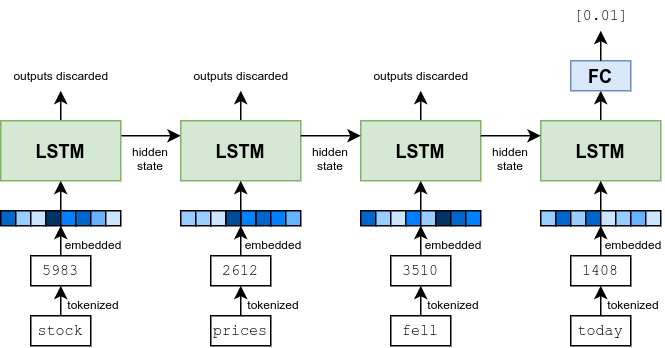

(You can open up `lstm.py` and read through it to get an idea of its implementation)


We have all of the components to train a model, now we need to wire them together.

Here we first create dataset object and create model class for LSTM. Once that's done, we will train the LSTM.


In [ ]:
import trainer
import torchmetrics
from text_dataset import TextDataset
from torch.utils.data import DataLoader
from lstm import LSTM

# Seed Torch's random number generator for reproducible results
torch.manual_seed(42)

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 40
LEARNING_RATE = 1e-3

# LSTM model parameters
NUM_CLASSES = 2
EMBEDDING_DIMS = 512
NUM_LAYERS = 4
HIDDEN_DIMS = 256

# Initialise two instances of TextDataset - one each for train and test.
# Read the implementation in text_dataset.py if you're not sure which arguments
# to provide.
# Also instantiate the train and test dataloaders.
train_dataset = TextDataset("dataset/train.csv")
test_dataset = TextDataset("dataset/test.csv")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# This code initialises an LSTM model.
model =  LSTM(NUM_CLASSES, train_dataset.vocab_size, EMBEDDING_DIMS, NUM_LAYERS, HIDDEN_DIMS)

# Initialise the Adam optimizer with learning rate set to LEARNING_RATE
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Set the loss_func to the cross entropy loss
loss_func = torch.nn.CrossEntropyLoss()

trainer.train_model(model, train_loader, test_loader, NUM_EPOCHS, loss_func,
                       optimizer, exp_name="LSTM")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0. Train loss: 0.626,  accuracy: 0.691. Test loss: 0.727 accuracy: 0.710
Epoch: 1. Train loss: 0.622,  accuracy: 0.691. Test loss: 0.747 accuracy: 0.710
Epoch: 2. Train loss: 0.620,  accuracy: 0.691. Test loss: 0.719 accuracy: 0.710
Epoch: 3. Train loss: 0.619,  accuracy: 0.691. Test loss: 0.749 accuracy: 0.710
Epoch: 4. Train loss: 0.618,  accuracy: 0.695. Test loss: 0.776 accuracy: 0.710
Epoch: 5. Train loss: 0.621,  accuracy: 0.691. Test loss: 0.740 accuracy: 0.710
Epoch: 6. Train loss: 0.619,  accuracy: 0.691. Test loss: 0.746 accuracy: 0.710
Epoch: 7. Train loss: 0.619,  accuracy: 0.691. Test loss: 0.760 accuracy: 0.710
Epoch: 8. Train loss: 0.620,  accuracy: 0.691. Test loss: 0.730 accuracy: 0.710
Epoch: 9. Train loss: 0.620,  accuracy: 0.691. Test loss: 0.727 accuracy: 0.710


## Train a Transformer

The focus of this lab is on transformer models, which have overtaken LSTMs in both performance and practicality, as it's quite easy to fine-tune a transformer model on a new task.

This is exactly what we'll do now - we'll download a pre-trained transformer from [HuggingFace](https://huggingface.co/) and train it on our dataset. As the implementation is already written, we won't need to write the model ourselves.

Our chosen model is called DistilBert, which is a smaller version of the popular [Bert](https://en.wikipedia.org/wiki/BERT_(language_model)) model. There are a number of checkpoints available for us to load which can be found [here](https://huggingface.co/transformers/pretrained_models.html). We will use "`distilbert-base-uncased`" as it offers good performance with the least parameters.



First fill in the code model code in the `distbert.py` file.  Once that's done, we will train the transformer model! While it's training, return to the W&B webapp and click "runs" on the top bar - you should see live results for the transformer training.

In [ ]:
from transformers import AutoModelForSequenceClassification
import utils
from distbert import DistBert

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

# Go to the distbert.py file to fill in the code for creating the
# "distilbert-base-uncased" model.
model = DistBert(device)

# Initialise the Adam optimizer with learning rate set to LEARNING_RATE
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Set the loss_func to the cross entropy loss
loss_func = torch.nn.CrossEntropyLoss()

trainer.train_model(model, train_loader, test_loader, NUM_EPOCHS, loss_func,
                       optimizer, exp_name = "Transformer")

# uncomment this line when you want to save the model
# utils.save_model_state(model, "Transformer")

Now let's use the save function at the end of training the transformer so our weights are persisted to disk.



In [ ]:
# Save the model
utils.save_model_state(model, "Transformer")

Once training has completed, open the file sidebar and check the `model_weights` directory - you should find your model weights file.

### Load and Use the Model

What good is saving a model to disk if you don't use it?

The next cell contains some code for loading the model and classifying your custom input.  

<font color="red">Read through the code in the next cell and run it.</font>



In [ ]:
import torch
import utils
from distbert import DistBert

# Load the model from huggingface
device = utils.get_training_device()
model = DistBert(device)

# Load model weights from disk
utils.load_model_state(model, "Transformer")

# Initialise a tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_sentiment(input_str):
    # Tokenize the given string
    encodings = tokenizer(input_str, truncation=True, padding=True)
    # Make tensor on the device
    inputs = torch.tensor(encodings["input_ids"], device=device)
    # Add batch dimension
    inputs = inputs.unsqueeze(0)

    # Get model predictions
    outputs = model(inputs)
    # Convert to a value of 0 or 1 (for negative/positive sentiment)
    sentiment = torch.argmax(outputs, -1)
    # Take only the first prediction (as we have a batch size of 1)
    sentiment = sentiment[0]

    return "Positive" if sentiment == 1 else "Negative"

Let's try it out! Make up some financial news headlines and see what the model has to say. It won't be perfect, but it should be quite good.

In [ ]:
my_input_string = "Apple stocks plummet 2 points in a single day"
print(predict_sentiment(my_input_string))

my_input_string = "Apple shareholders excited for early product release"
print(predict_sentiment(my_input_string))

That's a wrap! This lab has a lot of content (as usual), but the best part is that we can re-use this code for many types of projects.

All that's required for a new project is a data loader, model and training script.

Soon we'll extend this codebase to also include a basic web server so we can handle requests over the internet!